**PIPELINE**:

**Train**: 

1. $r_t = r_0 + c_1 t$

2. $c_1(\phi, \mu) \approx p_0(\mu) + p_1(\mu)\phi  + p_2(\mu) \phi^2 + \cdots$

3. New mapping: either $g: \mu \rightarrow c_1$ or $g: \mu \rightarrow (p_0, p_1, p_2, \cdots)$

**Test**:
1. Sample $\mu^{\ast}$

2. Push through $g$, get $c_1$

3. $r_t^{\ast} = r_0^{\ast} + c_1^{\ast} t$

4. Predictive uncertainty? 


5. Inference on $\mu$?? $\color{red}{\text{(details to follow)}}$

**Transfer**

(need some more reliable edge data for this, but using some limited samples)

1. Specify $r_0$

2. Specify $\mu$

3. Assume covariate shift i.e. shift in $\phi$ and $\mu$ (tricky for $\phi$? $\phi$ actually depends on $\mu$? or at least on orientation!) - can we make this conditional on $\phi$ and reframe?

4. Reweigh samples

5. Generate new predictions

Same concept as previous notebook, but trying to learn an approximate instead of exact GP to avoid memory intensive calculation.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

from sklearn.preprocessing import StandardScaler
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

from matplotlib import pyplot as plt

In [5]:
import re
import os

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
%matplotlib inline

In [8]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [9]:
import edge_utils as edut

Load data

In [10]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [11]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [12]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [13]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

Least Squares Fit (don't need non-linear because of independence of $k$ and $\tau$.

In [14]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [15]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [16]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [17]:
rd_2161 = getRValuesAllSims(ed_2161)

In [18]:
data_dim = rd_2161.shape[1]
data_dim

160

In [19]:
# param_dim = cme_params_to_augment.shape[1]
# param_dim

In [20]:
# augmented_r = np.zeros((rd_2161.shape[0], data_dim + param_dim, rd_2161.shape[2]))
# augmented_r[:, :(data_dim), :] = rd_2161
# for iii in range(rd_2161.shape[2]):
#     augmented_r[:, (data_dim):, iii] = cme_params_to_augment[iii, :]

In [21]:
def lin_velocity_func(x, t, y):
    return x[0] * t - y

In [22]:
def gen_velocities(t, c1):
    return c1 * t

In [23]:
from scipy.optimize import least_squares

In [24]:
def fit_velocity(edge_data_matrix, 
                 sim_data, simIdx=0, 
                theta=np.linspace(-31, 82, 160), 
                lsq_loss="soft_l1",
                fscale=0.1,
                x0 = [0.00517464 * 400]):
    """
    for a chosen sim ID, fit least squares to all valid times in edge data, varying with position angle.
    return matrix of size (n_theta x n_params), here n_params = 1
    """
    
    ntheta = len(theta)
    
    simID = sim_data[simIdx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=simIdx)
    
    r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times])
    
    # rescale valid_times
    # convert time to hours from minutes
    #     valid_times_hrs = valid_times / 60
    valid_times_rs = (valid_times - tMin) / (tMax - tMin)
    
    lsq_params = np.zeros((ntheta, 1))
    
    r_vals_valid = r_vals[valid_time_idx, :]
    
    r0 = r_vals_valid[0, :]
    
    
    t_train = valid_times_rs[1:]
    r_train = r_vals_valid[1:, :] - r0
    
    r_pred = np.zeros(np.shape(r_vals_valid))
    
    r_pred[0, :] = r0
    
    for pa_idx, pa in enumerate(theta):
        res_lsq = least_squares(lin_velocity_func,
                                x0,
                                loss=lsq_loss,
                                args=(t_train, r_train[:, pa_idx]),
                                bounds=(0, np.inf),
                                verbose=0)
        
        
        lsq_params[pa_idx, :] = res_lsq.x
        r_pred[1:, pa_idx] = gen_velocities(t_train, *res_lsq.x) + r0[pa_idx]
    
    return lsq_params, r_pred, r_vals_valid

In [25]:
# params_s0, r_pred_s0, r_vals_s0 = fit_velocity(ed_2161, sd_2161, simIdx=0, lsq_loss="linear")

In [26]:
# params_s0

In [27]:
orig_sd_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_modified])
orig_sd_idx.shape

(262,)

In [28]:
# c1_params = np.zeros((160, 1, len(sd_modified)))
# for i in range(len(sd_modified)):
#     params_sheeley, r_pred_sheeley, r_vals_sheeley = fit_velocity(ed_2161, 
#                                                                   sd_2161, 
#                                                                   simIdx=orig_sd_idx[i], 
#                                                                   lsq_loss="soft_l1")
    
#     c1_params[:, :, i] = params_sheeley
# # #     edut.plotTrainPredData1Model(r_vals_sheeley, r_pred_sheeley, ed_2161, sd_modified, simIdx=i, 
# # #                                   savefig=True,
# # #                                   savedir="./linear_velocity_fit_all_sims"
# # #                                  )

In [29]:
# np.save("c1_least_squares_correct.npy", c1_params)

In [30]:
c1_params = np.load("c1_least_squares_correct.npy")

In [31]:
def getDataForLinearFit(edge_data_matrix, 
                 sim_data, simIdx=0, 
                theta=np.linspace(-31, 82, 160)):
    ntheta = len(theta)
    
    simID = sim_data[simIdx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=simIdx)
    
    r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times])
    
    # rescale valid_times
    # convert time to hours from minutes
    #     valid_times_hrs = valid_times / 60
    valid_times_rs = (valid_times - tMin) / (tMax - tMin)
    
    r_vals_valid = r_vals[valid_time_idx, :]

    r0 = r_vals_valid[0, :]


    t_train = valid_times_rs[1:]
    r_train = r_vals_valid[1:, :] - r0

    return r_train, t_train

In [32]:
r_train203, t_train203 = getDataForLinearFit(ed_2161, sd_2161, simIdx=159)

In [33]:
# for sidx, sid in enumerate(sd_modified):
#     plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, sidx], label="")
#     plt.xlabel("phi")
#     plt.xlim((-31, 82))
#     plt.title("Sim {} c1".format(sid))
#     plt.savefig(os.path.join("c1_figs", "Sim_{:03d}_c1.png".format(sid)))
#     plt.close()

Text(0.5, 1.0, 'c1 selected')

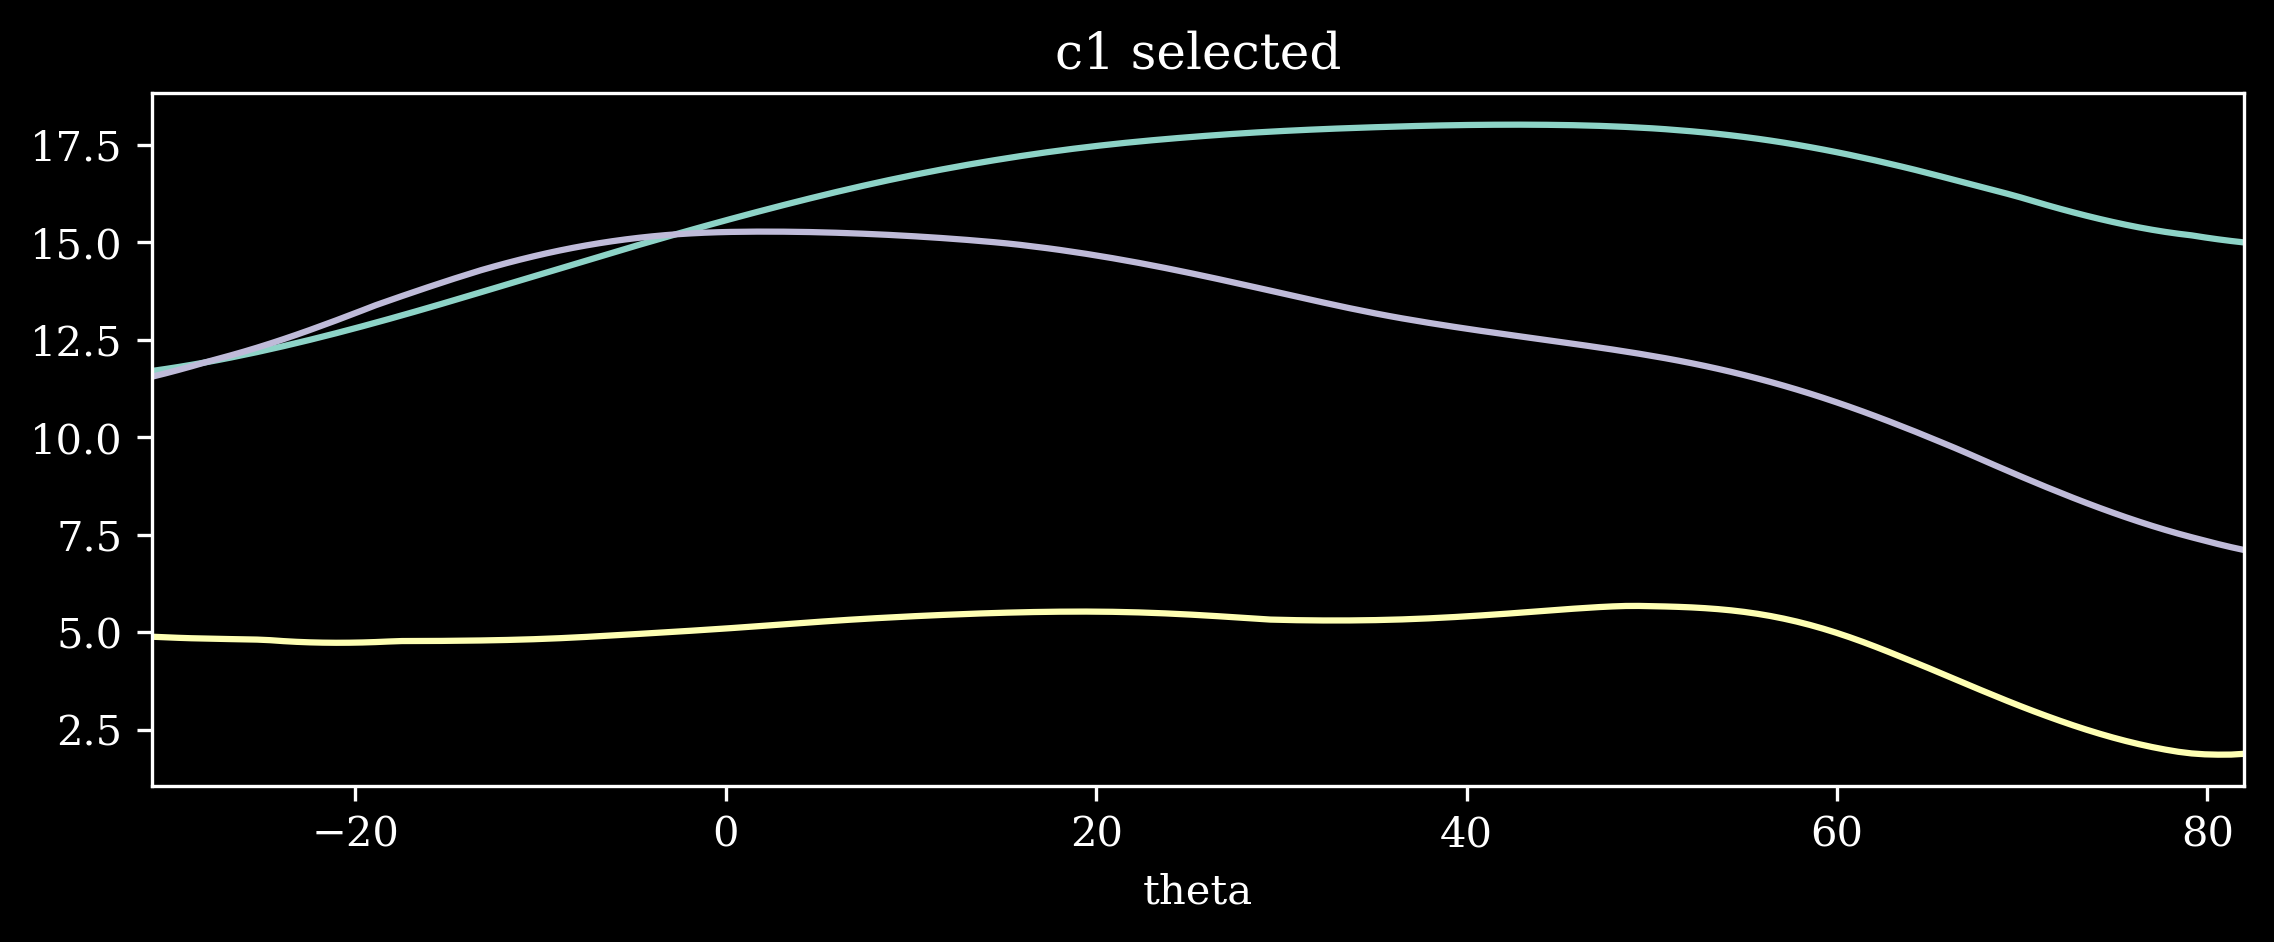

In [34]:
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 0], label="")
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 1], label="")
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 20], label="")
plt.xlabel("theta")
plt.xlim((-31, 82))
plt.title("c1 selected")

#### Load CME Parameters

In [35]:
cme_params = pd.read_csv("./restarts_CR2161.csv")
cme_params.head()

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4


In [36]:
bg_params = pd.read_csv("./backgrounds_CR2161.csv")

In [37]:
unique_bg = cme_params.restartdir.unique()
unique_bg

array([ 4, 12])

In [38]:
cme_param_bg_idx = []
for bg in unique_bg:
    cme_param_bg_idx.append(np.array((cme_params.restartdir == bg).to_list()))

In [39]:
bg_params_to_insert = np.zeros((cme_params.shape[0], bg_params.shape[1]))
for bg_idx, bg in enumerate(unique_bg):
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 0] = bg_params.FactorB0[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 1] = bg_params.PoyntingFluxPerBSi[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 2] = bg_params.LperpTimesSqrtBSi[bg - 1]

cme_params["FactorB0"] = pd.Series(bg_params_to_insert[:, 0])
cme_params["PoyntingFluxPerBSi"] = pd.Series(bg_params_to_insert[:, 1])
cme_params["LperpTimesSqrtBSi"] = pd.Series(bg_params_to_insert[:, 2])
cme_params["SimID"] = pd.Series(np.linspace(31, 330, 300))
sim_idx_successful = sd_2161 - 30 - 1
sim_idx_to_drop = np.setdiff1d(np.linspace(0, 299, 300), sim_idx_successful).astype(int).tolist()


cme_params.drop(["restartdir"], axis=1, inplace=True)
cme_params.drop(sim_idx_to_drop, inplace=True)
cme_params.drop(["SimID"], axis=1, inplace=True)
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.58375,22.526622,0.682075,204.725,1,4,0.8010,378833.7,147856.5
1,0.52625,6.919483,0.519179,164.225,1,4,0.8010,378833.7,147856.5
2,0.72625,5.087500,0.662022,233.975,1,4,0.8010,378833.7,147856.5
3,0.36125,18.360770,0.420743,200.675,-1,4,0.8010,378833.7,147856.5
4,0.69125,8.127120,0.735101,184.925,1,4,0.8010,378833.7,147856.5
...,...,...,...,...,...,...,...,...,...
294,0.73750,15.331483,0.721367,170.750,-1,5,1.3016,304514.4,283042.3
295,0.36250,32.665259,0.436133,197.750,-1,5,1.3016,304514.4,283042.3
296,0.46250,26.757500,0.443711,224.750,1,5,1.3016,304514.4,283042.3
297,0.76250,16.930533,0.874492,215.750,-1,5,1.3016,304514.4,283042.3


In [40]:
cme_p_min = cme_params.min()
cme_p_min.BStrength = 4.4516
cme_p_min.Radius = 0.3
cme_p_min.OrientationCme = 155
cme_p_min.iHelicity = -1
cme_p_min.ApexHeight = 0.2625
cme_p_min.realization = 1
cme_p_min.FactorB0 = 0.54
cme_p_min.PoyntingFluxPerBSi = 0.3e6
cme_p_min.LperpTimesSqrtBSi = 0.3e5

cme_p_min

Radius                     0.3000
BStrength                  4.4516
ApexHeight                 0.2625
OrientationCme           155.0000
iHelicity                 -1.0000
realization                1.0000
FactorB0                   0.5400
PoyntingFluxPerBSi    300000.0000
LperpTimesSqrtBSi      30000.0000
dtype: float64

In [41]:
cme_p_max = cme_params.max()
cme_p_max.BStrength = 47.4833
cme_p_max.Radius = 0.8
cme_p_max.OrientationCme = 245
cme_p_max.iHelicity = 1
cme_p_max.ApexHeight = 1
cme_p_max.realization = 12
cme_p_max.FactorB0 = 2.7
cme_p_max.PoyntingFluxPerBSi = 1.1e6
cme_p_max.LperpTimesSqrtBSi = 3e5

cme_p_max

Radius                8.000000e-01
BStrength             4.748330e+01
ApexHeight            1.000000e+00
OrientationCme        2.450000e+02
iHelicity             1.000000e+00
realization           1.200000e+01
FactorB0              2.700000e+00
PoyntingFluxPerBSi    1.100000e+06
LperpTimesSqrtBSi     3.000000e+05
dtype: float64

In [42]:
cme_params_norm = (cme_params - cme_p_min) / (cme_p_max - cme_p_min)
cme_params_norm

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506
...,...,...,...,...,...,...,...,...,...
294,0.8750,0.252834,0.622193,0.1750,0.0,0.363636,0.352593,0.005643,0.937194
295,0.1250,0.655648,0.235434,0.4750,0.0,0.363636,0.352593,0.005643,0.937194
296,0.3250,0.518360,0.245710,0.7750,1.0,0.363636,0.352593,0.005643,0.937194
297,0.9250,0.289994,0.829820,0.6750,0.0,0.363636,0.352593,0.005643,0.937194


In [43]:
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

**Split into train and test for GPs**

In [44]:
from numpy.random import Generator, PCG64
rng = np.random.default_rng(2023)

nTrain = int(np.floor(0.6 * len(sd_modified)))
nCalib = int(np.floor(0.2 * len(sd_modified)))
nTest = len(sd_modified) - nTrain - nCalib

nTrain, nTest, nCalib

(157, 53, 52)

In [45]:
len(sd_modified)

262

In [46]:
orig_sd_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_modified])

In [47]:
sd_train = np.sort(rng.choice(sd_modified, nTrain, replace=False))
sd_test_calib = np.setdiff1d(sd_modified, sd_train)
sd_calib = np.sort(rng.choice(sd_test_calib, nCalib, replace=False))
sd_test = np.setdiff1d(sd_test_calib, sd_calib)

sd_test, sd_calib

(array([ 36,  41,  43,  48,  50,  70,  79,  81,  85,  89,  92,  94, 101,
        114, 118, 119, 135, 140, 141, 151, 158, 164, 168, 169, 172, 174,
        178, 180, 188, 200, 204, 206, 211, 213, 214, 224, 230, 240, 243,
        246, 251, 254, 259, 261, 263, 267, 278, 288, 292, 307, 311, 320,
        328]),
 array([ 31,  35,  44,  46,  56,  61,  76,  95,  98, 105, 122, 123, 127,
        129, 143, 144, 146, 147, 153, 159, 175, 190, 194, 197, 205, 215,
        225, 231, 236, 239, 248, 249, 252, 255, 257, 258, 269, 274, 279,
        281, 284, 294, 298, 299, 302, 305, 306, 314, 316, 318, 319, 321]))

In [48]:
train_sd_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_train])
test_sd_idx  = np.array([np.where(sd_2161 == i)[0][0] for i in sd_test])

In [49]:
train_sd_idx_modified = np.array([np.where(sd_modified == i)[0][0] for i in sd_train])

In [50]:
test_sd_idx_modified = np.array([np.where(sd_modified == i)[0][0] for i in sd_test])

#### Process data

In [51]:
theta_grid_scaled = (theta_grid[0::2] - theta_grid[0])/(theta_grid[-1] - theta_grid[0])

In [52]:
theta_repeat = np.tile(theta_grid_scaled, len(train_sd_idx))

Check indexing

In [53]:
train_x_raw = cme_params_to_augment[train_sd_idx, :]
test_x_raw = cme_params_to_augment[test_sd_idx, :]

In [54]:
# train_x_raw.shape

In [55]:
# train_x_repeat = np.repeat(train_x_raw, len(theta_grid_scaled), axis=0)
# train_x_repeat.shape

In [56]:
# test_x_repeat = np.repeat(test_x_raw, len(theta_grid_scaled), axis=0)
# test_x_repeat.shape

In [57]:
# train_x_final = np.c_[theta_repeat, train_x_repeat]

In [58]:
# train_x_final.shape

In [59]:
# train_x_torch = torch.tensor(np.float32(train_x_final)).to(device)

In [60]:
# test_x_final = np.c_[np.tile(theta_grid_scaled, len(test_sd_idx)), test_x_repeat]

In [61]:
# test_x_final.shape

In [62]:
# test_x_torch = torch.tensor(np.float32(test_x_final)).to(device)

In [63]:
# c1_params_2d = np.squeeze(c1_params)

In [64]:
# train_y = c1_params_2d[0::2, train_sd_idx_modified].T.flatten()
# train_y.shape

In [65]:
# test_y = c1_params_2d[0::2, test_sd_idx_modified].T.flatten()
# test_y.shape

In [66]:
# train_y_torch = torch.tensor(np.float32(train_y)).to(device)

In [67]:
# train_y_torch.shape

In [68]:
# test_y_torch = torch.tensor(np.float32(test_y)).to(device)

### Fit Polynomials

Learn polynomial mapping between $c_1$ and flux rope parameters, then construct a GP using a small number of $c_1$ values and parameters. Alternately, learn the GP or a regular interpolator between the coefficients of the fitted polynomials and the flux rope parameters (eliminate dependence on position angle as an additional parameter)

The previous data processing applies to GP. Here we (probably) don't need to `tile` for position angle! - we need to see what sort of assumptions we make about the coefficients though.

In [69]:
# train_x_final, test_x_final
# train_y, test_y

In [70]:
c1_params.shape

(160, 1, 262)

In [71]:
c1_params_final = np.squeeze(c1_params)

In [72]:
c1_params_train = c1_params_final[:, train_sd_idx_modified].T
c1_params_test  = c1_params_final[:, test_sd_idx_modified].T

c1_params_train.shape, c1_params_test.shape

((157, 160), (53, 160))

In [73]:
train_x_raw.shape

(157, 9)

In [74]:
test_x_raw.shape

(53, 9)

In [75]:
fit_deg = 6

In [76]:
polynomial_coeffs = np.zeros((fit_deg + 1, c1_params_train.shape[0]))

In [77]:
for i in range(c1_params_train.shape[0]):
    polynomial_coeffs[:, i] = np.polyfit(theta_grid, c1_params_train[i, :], deg=fit_deg) 

In [78]:
# np.polyfit(theta_grid, c1_params_train[1, :], deg=fit_deg, full=True, cov=True)

In [79]:
polynomial_coeffs.shape

(7, 157)

In [80]:
polynomial_coeffs_test = np.zeros((fit_deg + 1, c1_params_test.shape[0]))

In [81]:
for i in range(c1_params_test.shape[0]):
    polynomial_coeffs_test[:, i] = np.polyfit(theta_grid, c1_params_test[i, :], deg=fit_deg) 

In [82]:
polynomial_coeffs_test.shape

(7, 53)

In [83]:
# plot polynomial coefficients p0 p1 p2 p3

# fig = plt.figure()
# for i in range(6):
#     plt.subplot(2, 3, i + 1)
#     plt.tight_layout()
#     plt.scatter(np.linspace(1, 157, 157), polynomial_coeffs[i, :])
#     plt.xlabel("Sim ID")
#     if i == 0:
#         plt.ylabel("Coefficient")
#     plt.title("p{}".format(5 - i))


In [84]:
theta_grid_scaled.shape

(80,)

In [85]:
pc1 = polynomial_coeffs[:, 0]
pc1

array([ 2.42376932e-10, -3.63726230e-08,  1.11267036e-06,  2.51640353e-05,
       -1.14732248e-03,  1.33934075e-02,  5.22663017e+00])

In [86]:
def getPredPolyFit(poly_coeffs, x):
    poly_sum = 0
    deg = len(poly_coeffs) - 1
    for i in range(len(poly_coeffs)):
        poly_sum = poly_sum + poly_coeffs[i] * (x**(deg - i))
        
    return poly_sum

In [87]:
# # plot to show fit (with selected points)

# for i in range(len(sd_train)):
#     plt.plot(np.linspace(-31, 82, 160), c1_params_train[i, :], label="true")
#     plt.plot(theta_grid[0::2], getPredPolyFit(polynomial_coeffs[:, i], theta_grid[0::2]), linestyle="--", label="fit")
#     plt.xlabel("phi")
#     plt.ylabel("c1")
#     plt.xlim((-31, 82))
#     plt.legend()
#     plt.title("Sim {}".format(sd_train[i]))
#     plt.savefig(os.path.join("c1_polynomial_fit", "sim_{:03d}.png".format(sd_train[i])))
#     plt.close()

_Interpolate polynomial coefficients as a function of flux rope parameters_ - this is _probably_ better. The dependence on position angle is not easy to account for as we saw the last time, and if we just take a few select angles, the interpolation especially of GP-style methods in between them may not be reliable.

this is a safer 2 stage method. once we have predicted coefficients with confidence intervals, use them to generate predictions of $c_1$.

**Multi-task GP** - correlated output dimensions, each output "task" (in our case, each polynomial coefficient) shares the same inputs $\mu$.

Reference: [GPyTorch Docs](https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html)

In [88]:
import scipy.interpolate

import torch
import gpytorch

In [89]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, tx, ty, lkl):
        super(MultitaskGPModel, self).__init__(tx, ty, lkl)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=7
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=7, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [90]:
train_x_torch_final = torch.tensor(np.float32(train_x_raw)).to(device)

In [91]:
train_x_torch_final.shape

torch.Size([157, 9])

In [92]:
train_y_torch_final = torch.tensor(np.float32(polynomial_coeffs.T)).to(device)

In [93]:
train_y_torch_final.shape

torch.Size([157, 7])

In [94]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7)
model = MultitaskGPModel(train_x_torch_final, train_y_torch_final, likelihood)

In [95]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [96]:
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

In [97]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [98]:
training_iterations = 1000

In [99]:
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x_torch_final)
    loss = -mll(output, train_y_torch_final)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/1000 - Loss: 2.148
Iter 2/1000 - Loss: 2.028
Iter 3/1000 - Loss: 1.930
Iter 4/1000 - Loss: 1.843
Iter 5/1000 - Loss: 1.765
Iter 6/1000 - Loss: 1.692
Iter 7/1000 - Loss: 1.622
Iter 8/1000 - Loss: 1.554
Iter 9/1000 - Loss: 1.488
Iter 10/1000 - Loss: 1.421
Iter 11/1000 - Loss: 1.355
Iter 12/1000 - Loss: 1.289
Iter 13/1000 - Loss: 1.225
Iter 14/1000 - Loss: 1.161
Iter 15/1000 - Loss: 1.100
Iter 16/1000 - Loss: 1.041
Iter 17/1000 - Loss: 0.983
Iter 18/1000 - Loss: 0.926
Iter 19/1000 - Loss: 0.870
Iter 20/1000 - Loss: 0.815
Iter 21/1000 - Loss: 0.762
Iter 22/1000 - Loss: 0.712
Iter 23/1000 - Loss: 0.663
Iter 24/1000 - Loss: 0.615
Iter 25/1000 - Loss: 0.567
Iter 26/1000 - Loss: 0.519
Iter 27/1000 - Loss: 0.471
Iter 28/1000 - Loss: 0.422
Iter 29/1000 - Loss: 0.375
Iter 30/1000 - Loss: 0.327
Iter 31/1000 - Loss: 0.279
Iter 32/1000 - Loss: 0.231
Iter 33/1000 - Loss: 0.183
Iter 34/1000 - Loss: 0.134
Iter 35/1000 - Loss: 0.086
Iter 36/1000 - Loss: 0.038
Iter 37/1000 - Loss: -0.010
Iter 38/1

Iter 304/1000 - Loss: -2.256
Iter 305/1000 - Loss: -2.304
Iter 306/1000 - Loss: -2.273
Iter 307/1000 - Loss: -2.304
Iter 308/1000 - Loss: -2.278
Iter 309/1000 - Loss: -2.291
Iter 310/1000 - Loss: -2.301
Iter 311/1000 - Loss: -2.293
Iter 312/1000 - Loss: -2.312
Iter 313/1000 - Loss: -2.294
Iter 314/1000 - Loss: -2.307
Iter 315/1000 - Loss: -2.301
Iter 316/1000 - Loss: -2.298
Iter 317/1000 - Loss: -2.308
Iter 318/1000 - Loss: -2.300
Iter 319/1000 - Loss: -2.311
Iter 320/1000 - Loss: -2.307
Iter 321/1000 - Loss: -2.309
Iter 322/1000 - Loss: -2.313
Iter 323/1000 - Loss: -2.308
Iter 324/1000 - Loss: -2.313
Iter 325/1000 - Loss: -2.310
Iter 326/1000 - Loss: -2.313
Iter 327/1000 - Loss: -2.314
Iter 328/1000 - Loss: -2.314
Iter 329/1000 - Loss: -2.316
Iter 330/1000 - Loss: -2.315
Iter 331/1000 - Loss: -2.313
Iter 332/1000 - Loss: -2.303
Iter 333/1000 - Loss: -2.274
Iter 334/1000 - Loss: -2.283
Iter 335/1000 - Loss: -2.285
Iter 336/1000 - Loss: -2.302
Iter 337/1000 - Loss: -2.282
Iter 338/1000 

Iter 598/1000 - Loss: -2.275
Iter 599/1000 - Loss: -2.255
Iter 600/1000 - Loss: -2.297
Iter 601/1000 - Loss: -2.254
Iter 602/1000 - Loss: -2.259
Iter 603/1000 - Loss: -2.259
Iter 604/1000 - Loss: -2.291
Iter 605/1000 - Loss: -2.285
Iter 606/1000 - Loss: -2.266
Iter 607/1000 - Loss: -2.302
Iter 608/1000 - Loss: -2.303
Iter 609/1000 - Loss: -2.282
Iter 610/1000 - Loss: -2.310
Iter 611/1000 - Loss: -2.312
Iter 612/1000 - Loss: -2.293
Iter 613/1000 - Loss: -2.310
Iter 614/1000 - Loss: -2.320
Iter 615/1000 - Loss: -2.304
Iter 616/1000 - Loss: -2.311
Iter 617/1000 - Loss: -2.322
Iter 618/1000 - Loss: -2.311
Iter 619/1000 - Loss: -2.312
Iter 620/1000 - Loss: -2.323
Iter 621/1000 - Loss: -2.318
Iter 622/1000 - Loss: -2.314
Iter 623/1000 - Loss: -2.321
Iter 624/1000 - Loss: -2.322
Iter 625/1000 - Loss: -2.317
Iter 626/1000 - Loss: -2.320
Iter 627/1000 - Loss: -2.324
Iter 628/1000 - Loss: -2.320
Iter 629/1000 - Loss: -2.321
Iter 630/1000 - Loss: -2.324
Iter 631/1000 - Loss: -2.323
Iter 632/1000 

Iter 886/1000 - Loss: -2.334
Iter 887/1000 - Loss: -2.334
Iter 888/1000 - Loss: -2.334
Iter 889/1000 - Loss: -2.334
Iter 890/1000 - Loss: -2.331
Iter 891/1000 - Loss: -2.321
Iter 892/1000 - Loss: -2.291
Iter 893/1000 - Loss: -2.235
Iter 894/1000 - Loss: -2.263
Iter 895/1000 - Loss: -2.256
Iter 896/1000 - Loss: -2.225
Iter 897/1000 - Loss: -2.221
Iter 898/1000 - Loss: -2.248
Iter 899/1000 - Loss: -2.245
Iter 900/1000 - Loss: -2.282
Iter 901/1000 - Loss: -2.253
Iter 902/1000 - Loss: -2.240
Iter 903/1000 - Loss: -2.194
Iter 904/1000 - Loss: -2.063
Iter 905/1000 - Loss: -2.242
Iter 906/1000 - Loss: -2.177
Iter 907/1000 - Loss: -2.143
Iter 908/1000 - Loss: -1.943
Iter 909/1000 - Loss: -1.976
Iter 910/1000 - Loss: -2.047
Iter 911/1000 - Loss: -2.048
Iter 912/1000 - Loss: -2.017
Iter 913/1000 - Loss: -2.072
Iter 914/1000 - Loss: -2.077
Iter 915/1000 - Loss: -2.076
Iter 916/1000 - Loss: -2.094
Iter 917/1000 - Loss: -2.111
Iter 918/1000 - Loss: -2.116
Iter 919/1000 - Loss: -2.114
Iter 920/1000 

In [100]:
# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [101]:
test_x_torch_final = torch.tensor(np.float32(test_x_raw)).to(device)
test_y_torch_final = torch.tensor(np.float32(polynomial_coeffs_test.T)).to(device)

In [102]:
test_x_torch_final.shape, test_y_torch_final.shape

(torch.Size([53, 9]), torch.Size([53, 7]))

In [103]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x_torch_final))
    mean_pred = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

/Users/ajivani/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [109]:
observed_pred.stddev.shape

/Users/ajivani/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


torch.Size([53, 7])

In [104]:
lower.shape, upper.shape

(torch.Size([53, 7]), torch.Size([53, 7]))

In [105]:
err0 = np.vstack((np.abs(lower[:, 0].numpy()), upper[:, 0].numpy()))

Text(0, 0.5, 'p6')

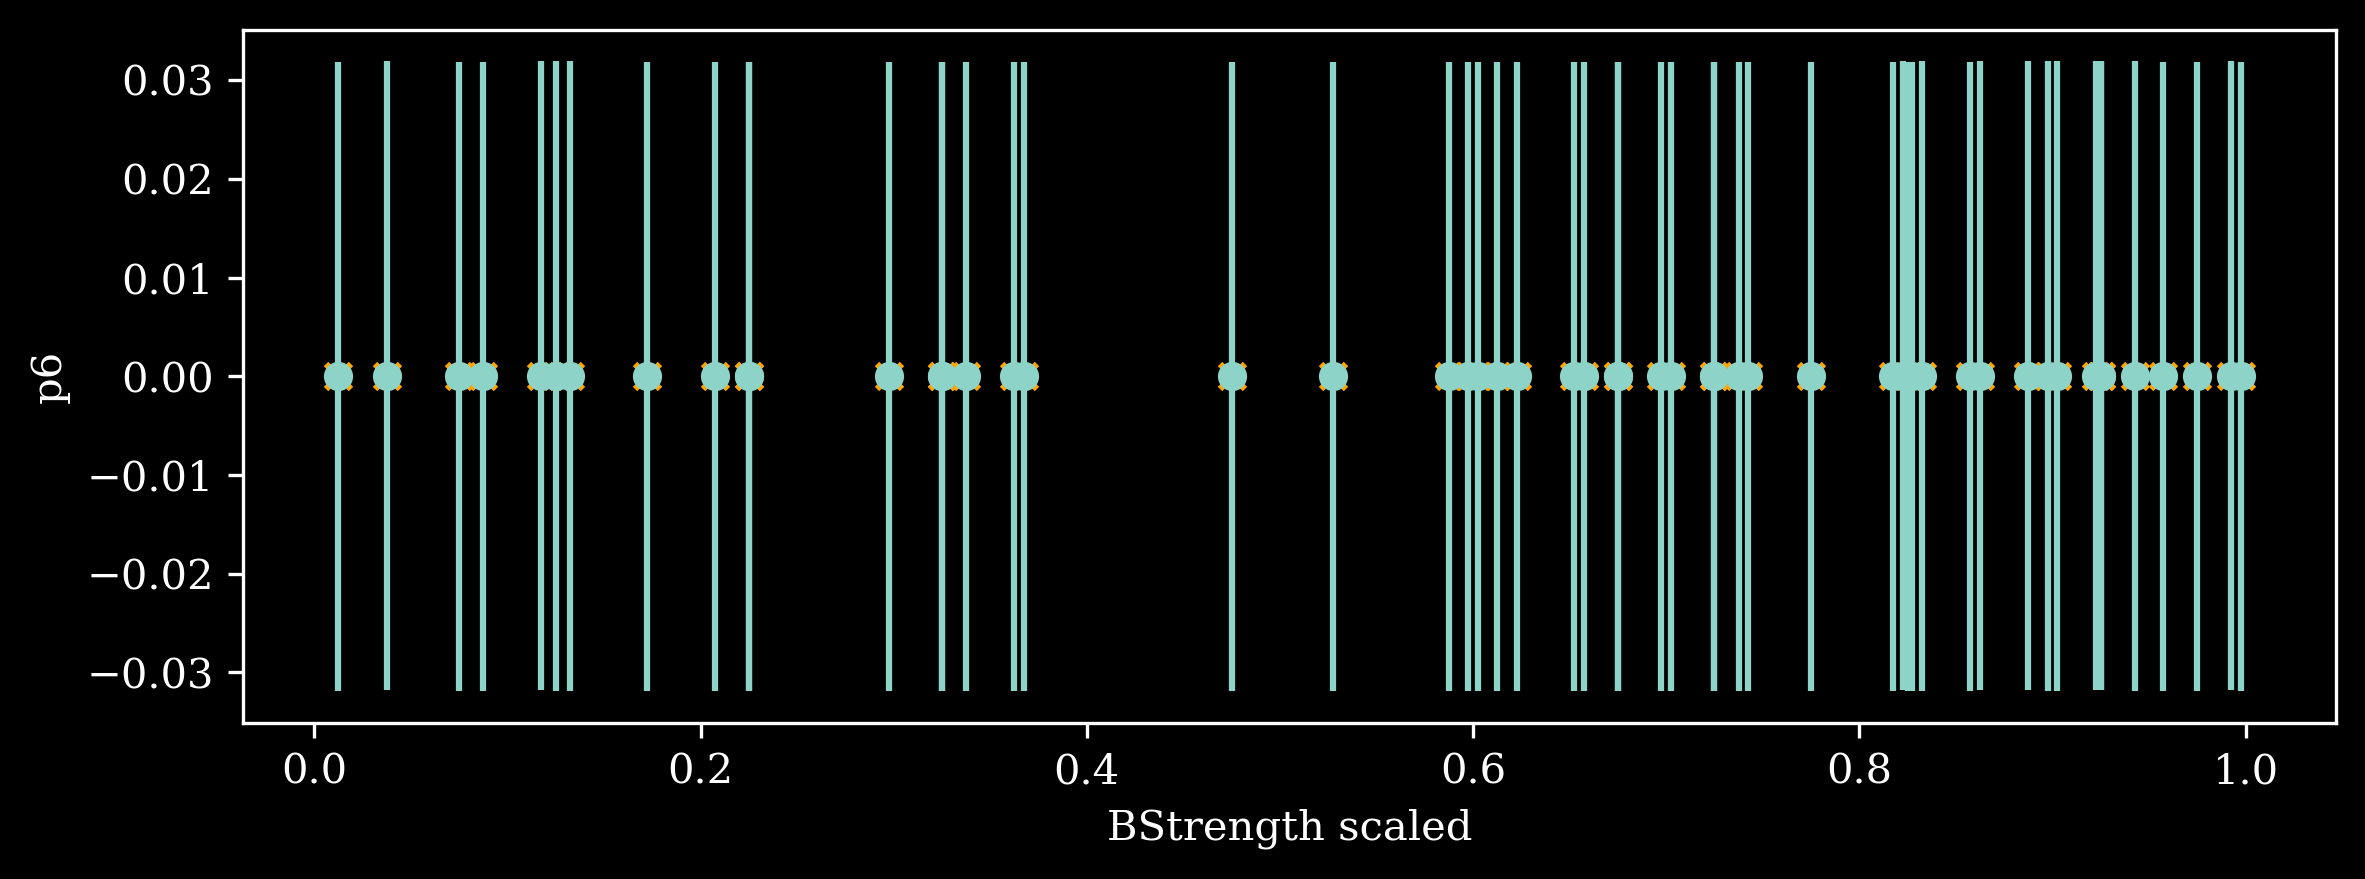

In [106]:
fig = plt.figure()
plt.errorbar(test_x_torch_final[:, 0], 
             mean_pred[:, 0], 
             yerr=err0,
             fmt="o"
            )
plt.scatter(test_x_torch_final[:, 0],
           test_y_torch_final[:, 0],
           marker='x',
           c='orange')
plt.xlabel("BStrength scaled")
plt.ylabel("p6")

Text(0, 0.5, 'p1')

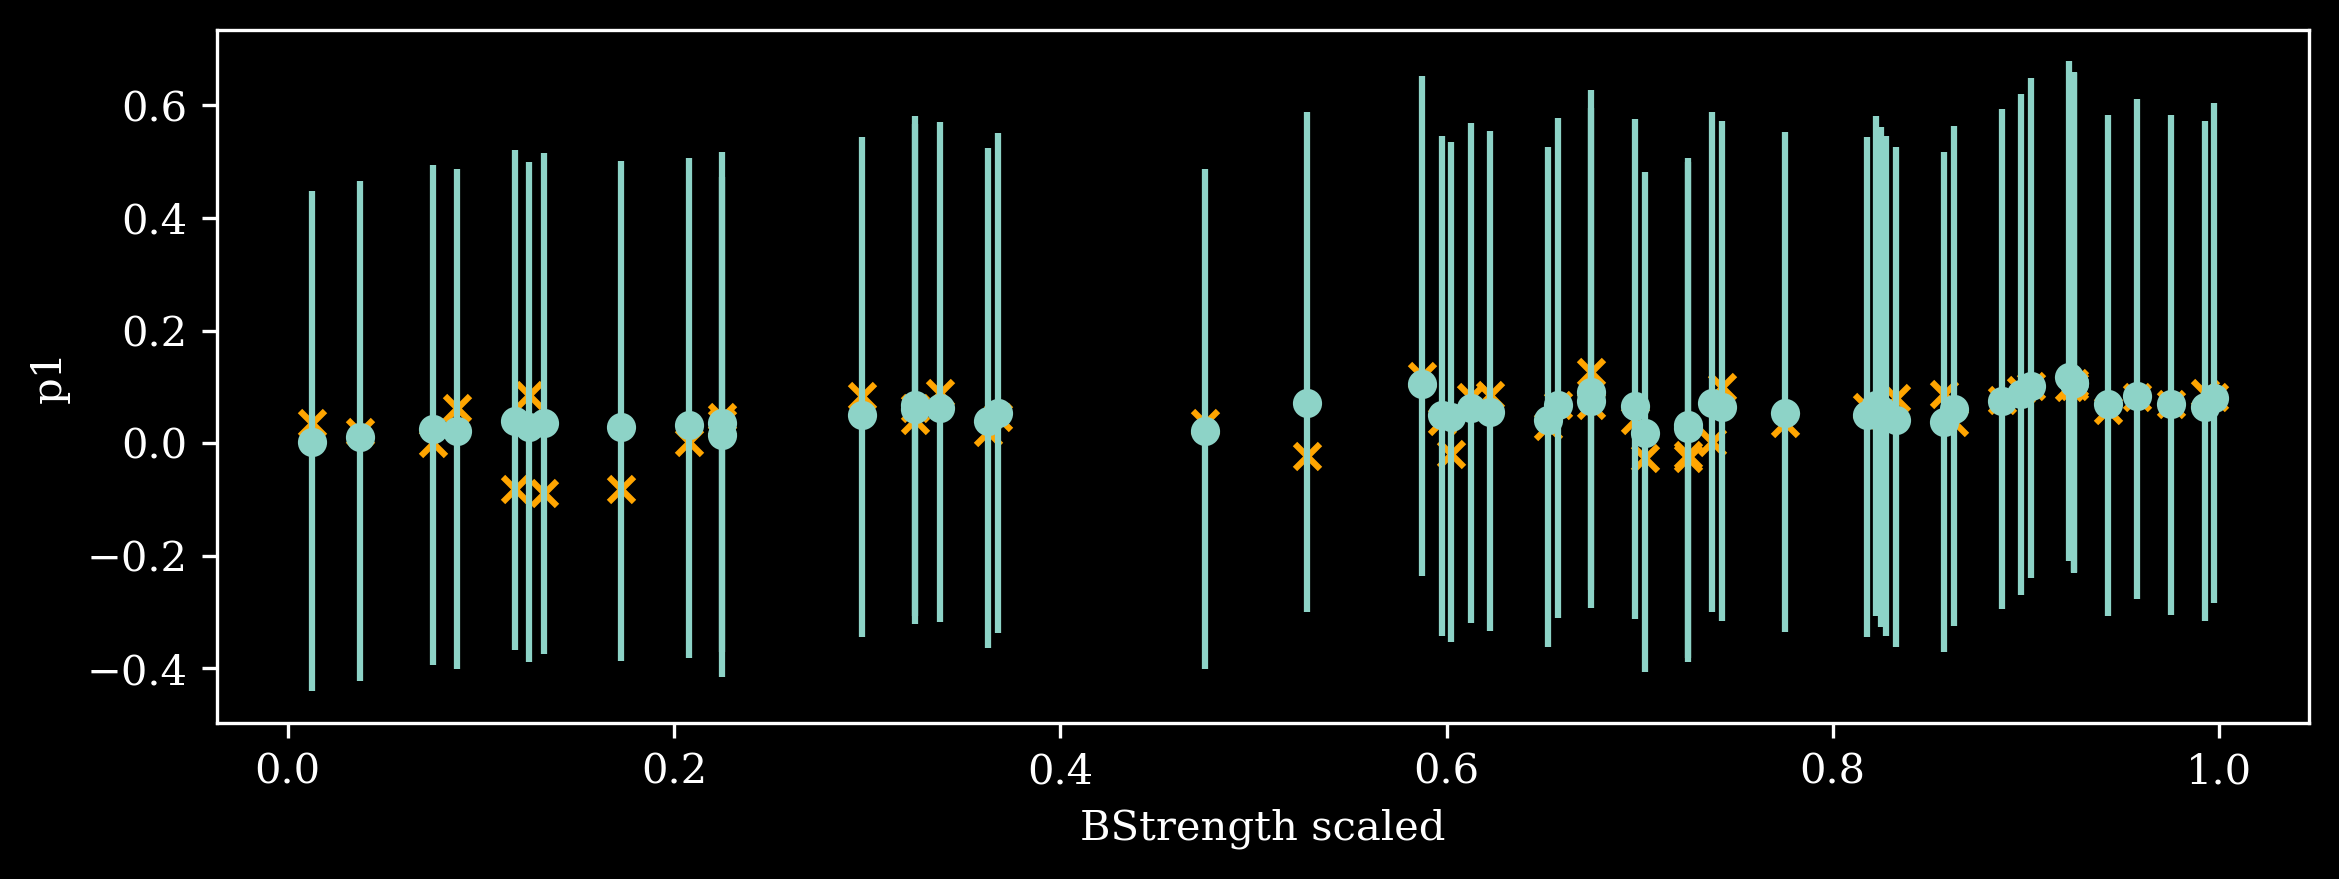

In [107]:
err_lin = np.vstack((np.abs(lower[:, -2].numpy()), upper[:, -2].numpy()))

plt.scatter(test_x_torch_final[:, 0],
           test_y_torch_final[:, -2],
           marker='x',
           c='orange')

plt.errorbar(test_x_torch_final[:, 0],
             mean_pred[:, -2], 
             yerr=err_lin,
             fmt="o"
            )

plt.xlabel("BStrength scaled")
plt.ylabel("p1")

Text(0, 0.5, 'p0')

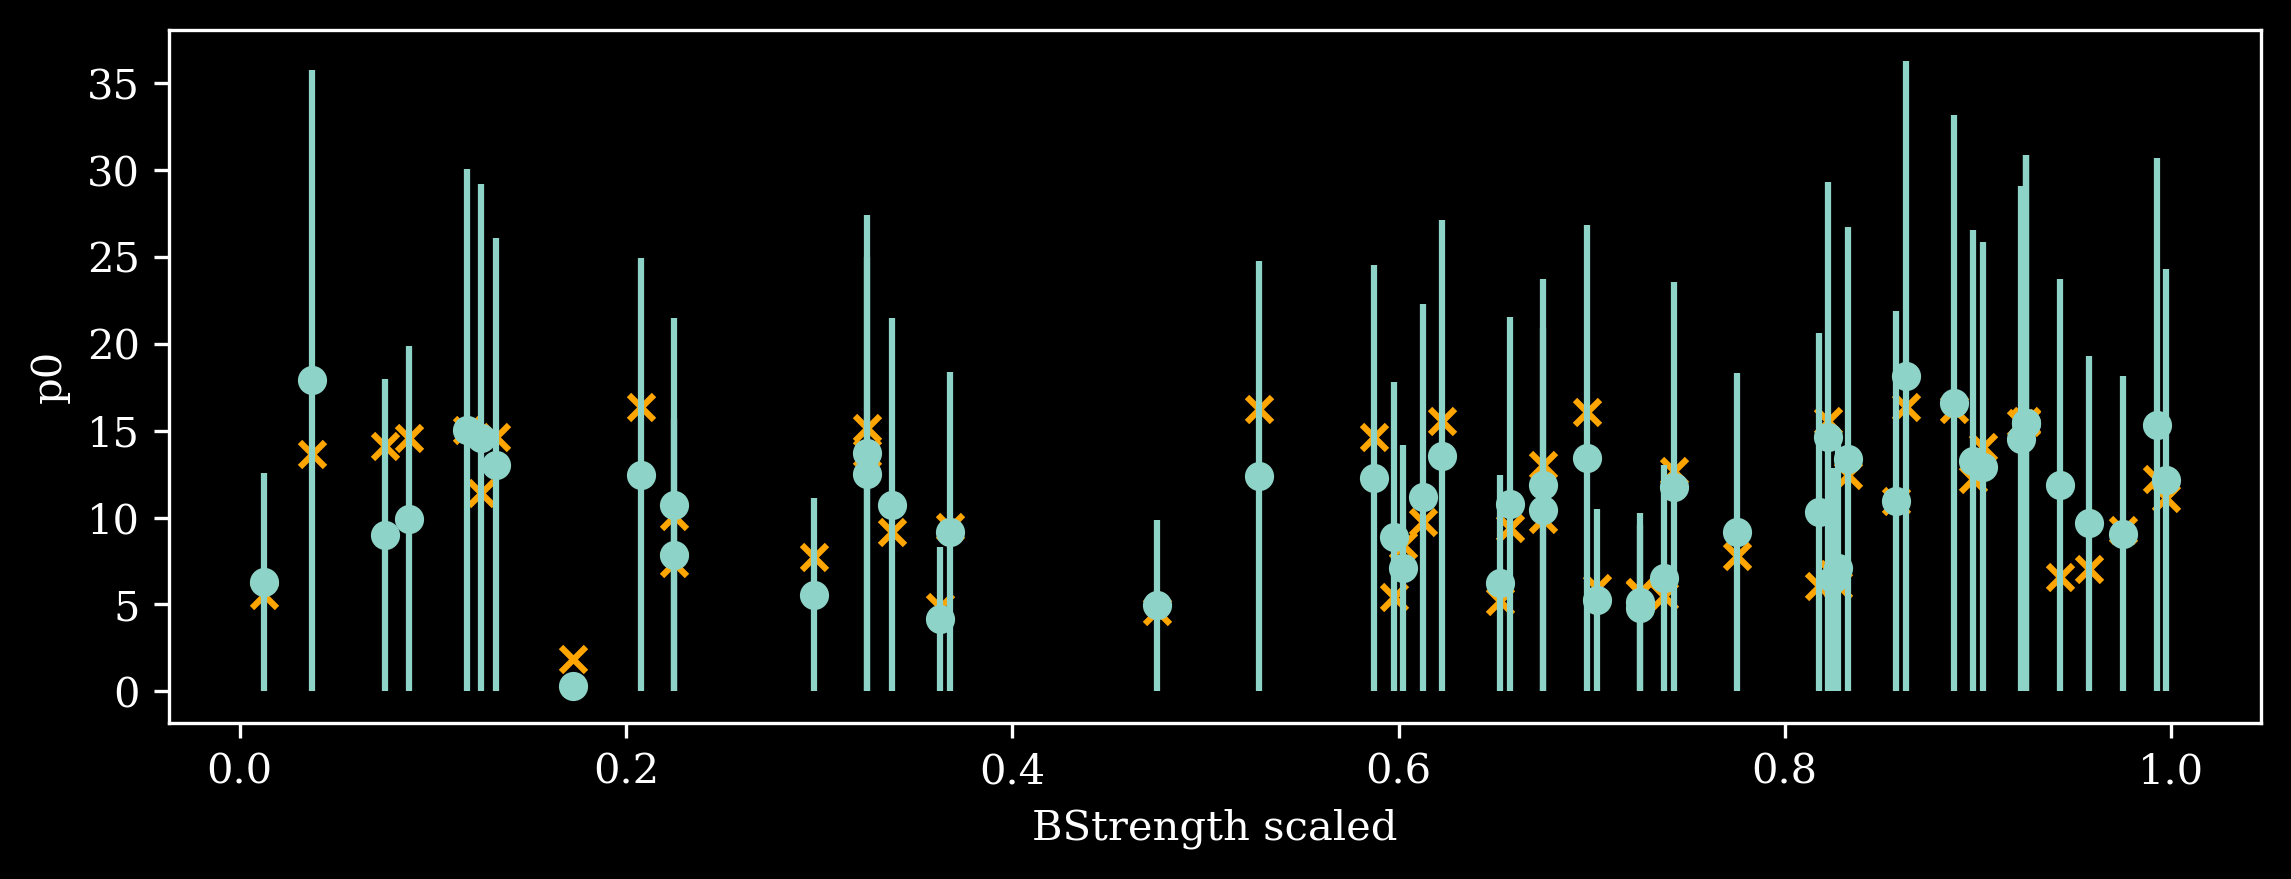

In [108]:
err_constant = np.vstack((np.abs(lower[:, -1].numpy()), upper[:, -1].numpy()))

plt.scatter(test_x_torch_final[:, 0],
           test_y_torch_final[:, -1],
           marker='x',
           c='orange')
plt.errorbar(test_x_torch_final[:, 0],
             mean_pred[:, -1], 
             yerr=err_constant,
             fmt="o"
            )
plt.xlabel("BStrength scaled")
plt.ylabel("p0")

_Results on test data with uncertainty_ first for $c_1$ (this would include only confidence from GP and not possible polynomial fitting error which could be a drawback), then the full series.

In [ ]:
c1_params_test.shape

Predict $c_1$ by sampling from the posterior predictive distribution of $p$

In [110]:
post_pred = torch.distributions.Normal(observed_pred.mean, observed_pred.stddev)

/Users/ajivani/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [123]:
post_pred.sample().shape

torch.Size([53, 7])

Draw 1000 samples, store them in a tensor, fit $c_1$ by 6 degree polynomial and get results.

In [119]:
n_post_samples = 1000

In [126]:
p_test_samples = np.zeros((test_x_torch_final.shape[0], fit_deg + 1, n_post_samples))
for i in range(n_post_samples):
    p_test_samples[:, :, i] = post_pred.sample().numpy()

print("Generated {} samples from posterior".format(n_post_samples))

Generated 1000 samples from posterior


In [138]:
p_test_samples[0, :, 0].shape

(7,)

In [120]:
test_x_torch_final.shape

torch.Size([53, 9])

In [129]:
c1_test = np.zeros((test_x_torch_final.shape[0], 160, n_post_samples))

for i in range(n_post_samples):
    for j in range(test_x_torch_final.shape[0]):
        c1_test[j, :, i] = getPredPolyFit(p_test_samples[j, :, i], theta_grid)

print("Generated {} test velocities with {} replicates".format(test_x_torch_final.shape[0], n_post_samples))

Generated 53 test velocities with 1000 replicates


In [131]:
mean_c1 = np.mean(c1_test, axis=2)
std_c1 = np.std(c1_test, axis=2)

mean_c1.shape, std_c1.shape

((53, 160), (53, 160))

Plot a few test velocities versus the actual and examine outputs

In [132]:
c1_params_test.shape

(53, 160)

(0.0, 20.0)

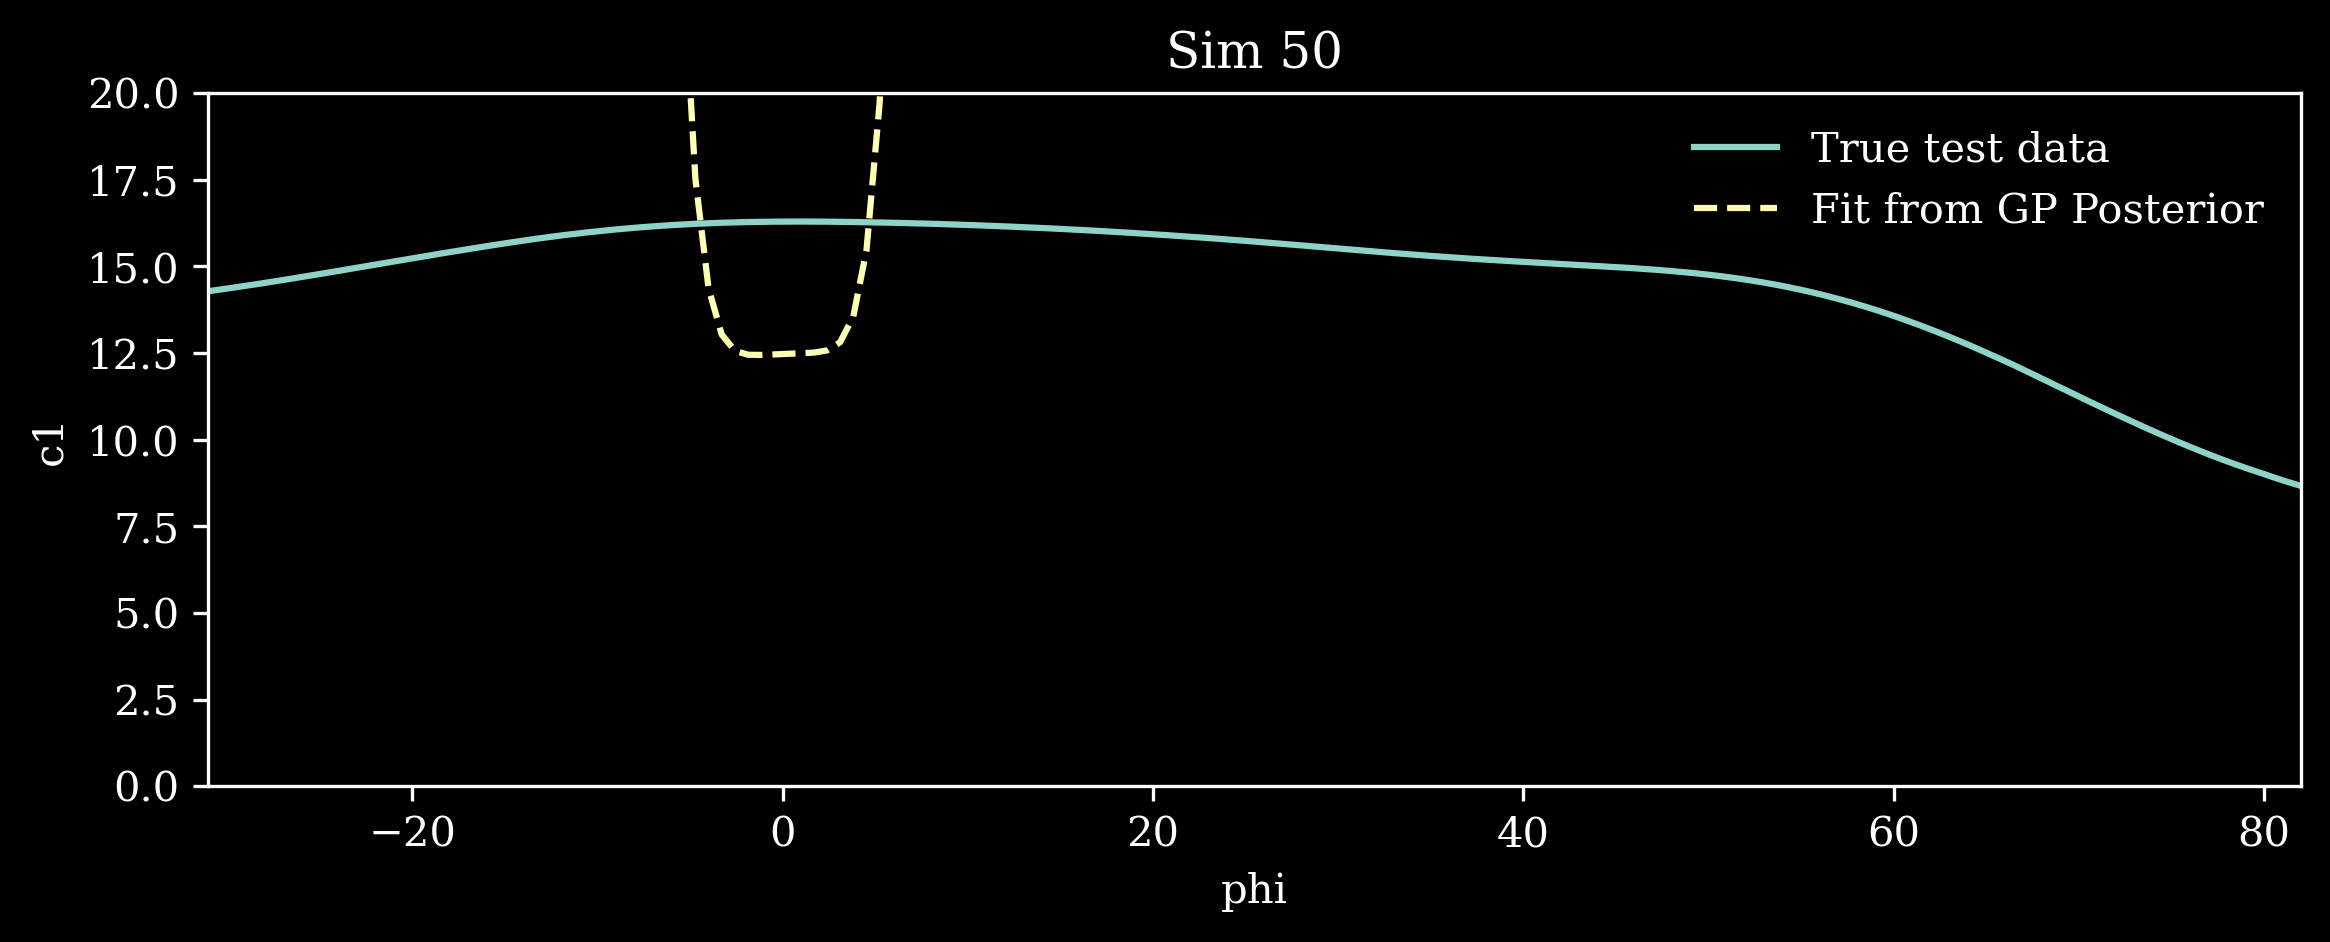

In [140]:
# for i in range(len(sd_train)):
plt.plot(theta_grid, c1_params_test[4, :], label="True test data")
plt.plot(theta_grid, mean_c1[4, :], linestyle="--", label="Fit from GP Posterior")
plt.xlabel("phi")
plt.ylabel("c1")
plt.xlim((-31, 82))
plt.legend()
plt.title("Sim {}".format(sd_test[4]))
plt.ylim((0, 20))
# plt.savefig(os.path.join("c1_polynomial_fit", "sim_{:03d}.png".format(sd_train[i])))
# plt.close()

#### Alternate: Fit GP to c1 directly.

This means position angle is also an independent parameter (I don't know if this is a good thing or a bad thing at this point), unless we treat this as a multitask GP too!!

UQ with conditional predictions?

_Transfer methods?_

**Plot histograms of CME Params from 2 Events (domain shift)?**

#### Try Linear Fit for Velocity Again

**Next Steps?**